In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [43]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Cleansing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [44]:
#As bmi contains null values
df.bmi = df.bmi.fillna(-99)

In [45]:
# define target variable
target = df.stroke

# remove stroke column
df = df.drop(['stroke'], axis=1)

# calc frequencies
target_count = target.value_counts()
print(target_count)
print('Percentage of strokes [1]:', np.round(100*target_count[1] / target_count.sum(),2), '%')

0    4861
1     249
Name: stroke, dtype: int64
Percentage of strokes [1]: 4.87 %


In [46]:
ever_married_mapping = {'No': 0, 'Yes': 1}
df['ever_married'] = df['ever_married'].map(ever_married_mapping)
Residence_type_mapping = {'Rural': 0, 'Urban': 1}
df['Residence_type'] = df['Residence_type'].map(Residence_type_mapping)

datasetDummies_gender = pd.get_dummies(df['gender'], prefix = 'gender_encoded')
datasetDummies_work_type = pd.get_dummies(df['work_type'], prefix = 'work_type_encoded') 
datasetDummies_smoking_status = pd.get_dummies(df['smoking_status'], prefix = 'smoking_status_encoded')

df.drop("gender", axis=1, inplace=True)
df.drop("work_type", axis=1, inplace=True)
df.drop("smoking_status", axis=1, inplace=True)

In [47]:
df = pd.concat([df, datasetDummies_gender], axis=1)
df = pd.concat([df, datasetDummies_work_type], axis=1)
df = pd.concat([df, datasetDummies_smoking_status], axis=1)
df.head()

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_encoded_Female,gender_encoded_Male,gender_encoded_Other,work_type_encoded_Govt_job,work_type_encoded_Never_worked,work_type_encoded_Private,work_type_encoded_Self-employed,work_type_encoded_children,smoking_status_encoded_Unknown,smoking_status_encoded_formerly smoked,smoking_status_encoded_never smoked,smoking_status_encoded_smokes
0,9046,67.0,0,1,1,1,228.69,36.6,0,1,0,0,0,1,0,0,0,1,0,0
1,51676,61.0,0,0,1,0,202.21,-99.0,1,0,0,0,0,0,1,0,0,0,1,0
2,31112,80.0,0,1,1,0,105.92,32.5,0,1,0,0,0,1,0,0,0,0,1,0
3,60182,49.0,0,0,1,1,171.23,34.4,1,0,0,0,0,1,0,0,0,0,0,1
4,1665,79.0,1,0,1,0,174.12,24.0,1,0,0,0,0,0,1,0,0,0,1,0


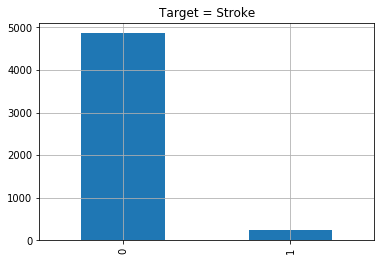

In [58]:
target_count.plot(kind='bar')
plt.title('Target = Stroke')
plt.grid()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], target, test_size=0.30,random_state=42)


## Model building

In [61]:
model = Sequential()
model.add(Dense(32, input_dim=19, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
3577/3577 [==============================] - 4s 1ms/step - loss: 2.5531 - accuracy: 0.7615
Epoch 2/50
3577/3577 [==============================] - 1s 293us/step - loss: 0.1935 - accuracy: 0.9561
Epoch 3/50
3577/3577 [==============================] - 1s 273us/step - loss: 0.1858 - accuracy: 0.9555
Epoch 4/50
3577/3577 [==============================] - 1s 243us/step - loss: 0.1774 - accuracy: 0.9558
Epoch 5/50
3577/3577 [==============================] - 1s 266us/step - loss: 0.1738 - accuracy: 0.9558
Epoch 6/50
3577/3577 [==============================] - 1s 277us/step - loss: 0.1716 - accuracy: 0.95580s - loss: 0.1792 - accuracy: 0.95 - ETA: 0s - loss: 0.1816 - accura
Epoch 7/50
3577/3577 [==============================] - 1s 346us/step - loss: 0.1662 - accuracy: 0.9555
Epoch 8/50
3577/3577 [==============================] - 1s 254us/step - loss: 0.1668 - accuracy: 0.9561
Epoch 9/50
3577/3577 [==============================] - 1s 269us/step - loss: 0.1634 - accuracy: 0.955